In [1]:
!pip3 install --user numpy pandas scipy matplotlib
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
# import plotly.plotly as py
# import plotly.figure_factory as ff
# from plotly.graph_objs import *

In [2]:
%matplotlib inline

In [3]:
def toLabel(name):
    if '-' in name:
        tokens = name.split('-')
        return '{} ({})'.format(tokens[0].upper(), tokens[1].title())
    else:
        return name.title()

[toLabel(n) for n in ['ilp-direct', 'ilp-external', 'simple']]

['ILP (Direct)', 'ILP (External)', 'Simple']

In [4]:
bar_width = 0.2
solver_names = ['ilp-direct', 'ilp-external', 'simple', 'mh-naive']
patterns = ['❌', '❌', '✔', '➖']
colors = [c[4:] for c in (sorted(mcolors.TABLEAU_COLORS.keys())) if 'dark'+c[4:] in mcolors.CSS4_COLORS]
colors.reverse()

In [5]:
def load(name, show_head=False):
    data = pd.read_csv(name)
    data['name'] = data.comp.astype(str).str.cat(
        [data.impl.astype(str),
         data.conf.astype(str),
         data.req.astype(str)], sep='-')
    if show_head:
        data.head()
    return data

In [6]:
def add_gen_and_solve(ax, index, i, solver_name, df, suffix, printStatus=True):
    pattern_index = 2 * df.get(solver_name + 'Valid' + suffix) + df.get(solver_name + 'TimeOut' + suffix)
    genTimes = df.get(solver_name + 'Gen' + suffix)
    if genTimes is not None:
        ax.bar(index + i * bar_width, genTimes, bar_width,
                #label=toLabel(solver_name) + "[GEN]",
                color='dark' + colors[i])
    solvTimes = df.get(solver_name + 'Solved' + suffix)
    solvBars = None
    if solvTimes is not None:
        solvBars = ax.bar(index + i * bar_width, solvTimes, bar_width,
                label=toLabel(solver_name),
                bottom=genTimes,
                color=colors[i])
    if printStatus and solvBars is not None:
        for rect, pi in zip(solvBars, pattern_index):
            height = rect.get_height()
            #print(rect.get_y(), height)
            ax.text(rect.get_x() + rect.get_width() / 2, max(5, rect.get_y() + height),
                     patterns[pi], fontname='symbola', 
                     ha='center', va='bottom', color=colors[i])


In [7]:
def create_single(name, suffix='Hard'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    data = load(name)
    index = np.arange(len(data.name))
    for i, solver_name in enumerate(solver_names):
        add_gen_and_solve(ax, index, i, solver_name, data, suffix, False)

    plt.xticks(rotation=90)
    plt.title("Solving time for hard problem")
    plt.xlabel('Comp-Impl-Config-Request')
    plt.ylabel('Solving time [ms]')
    plt.yscale("log")

    plt.xticks(index + bar_width / len(solver_names), data.name.astype(str))
    plt.legend()
    plt.tight_layout()
    plt.show()

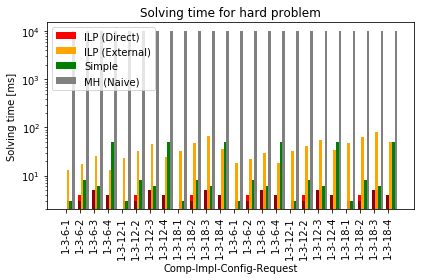

In [8]:
create_single('incremental/handcrafted-benchmark-1.csv')

In [9]:
def make_plot(name, df, ax, solver_names=solver_names, suffix='Hard'):
    index = np.arange(len(df.name))
    for i, solver_name in enumerate(solver_names):
        add_gen_and_solve(ax, index, i, solver_name, df, suffix)
        ax.set_title(name)

    plt.sca(ax)
    plt.yscale("log")
    plt.xticks(rotation=90)
    plt.xticks(index + bar_width / len(solver_names), list(df.name))

In [10]:
def create_row(name):
    data = load(name)
    groupByReq = data.groupby('req')
    nrDifferentRequests = len(groupByReq)
    print (nrDifferentRequests)

    fig, axs = plt.subplots(1, nrDifferentRequests, sharey=True)
    plt.suptitle("Solving time for hard problem", fontsize=16)
    #fig.autofmt_xdate()
    #print (axs)
    for (name, df), ax in zip(groupByReq, axs.flatten()):
        #print (df['ilp-externalSolvedHard'])
        make_plot('req=' + str(name), df, ax, ['ilp-external'])

    ## Create shared axes title
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    plt.xlabel("Comp-Impl-Config-Request", labelpad=50)
    plt.ylabel("Solving time [ms]")

    plt.show()

4


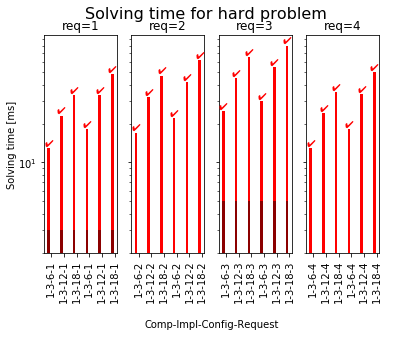

In [11]:
create_row('incremental/handcrafted-benchmark-1.csv')

In [12]:
def make_plot_in_grid(name, df, ax, suffix, solver_names=solver_names):
    index = np.arange(len(df.name))
    for i, solver_name in enumerate(solver_names):
        add_gen_and_solve(ax, index, i, solver_name, df, suffix)
        ax.set_title(name, visible=name is not None)

    plt.sca(ax)
    plt.yscale("log")
    plt.xticks(index + bar_width / len(solver_names), list(df.conf))

In [13]:
def create_grid_plot(name, suffix='Hard'):
    data = load(name)
    groupByResRat = data.groupby('res')
    nrDifferentRatios = len(groupByResRat)
    nrDifferentRequests = len(data.req.unique())
    print ("nrDifferentRequests:", nrDifferentRequests, "nrDifferentRatios:", nrDifferentRatios)

    fig, axs = plt.subplots(nrDifferentRatios, nrDifferentRequests, sharey=True, figsize=(12, 12))
    plt.suptitle("Solving time for hard problem", fontsize=16)

    #print (axs)
    firstResRatio = True
    for (resRatio, df), axs_res_ratio in zip(groupByResRat, axs):
        lastAx = axs_res_ratio[-1]
        lastAx.set_ylabel('rr=' + str(resRatio), rotation=0)
        #lastAx.yaxis.set_label_position("right")
        lastAx.yaxis.set_label_coords(1.3,0.5)
        #print (resRatio)
        for (reqNumber, df_inner), ax in zip(df.groupby('req'), axs_res_ratio):
            name = 'req=' + str(reqNumber) if firstResRatio else None
            #print (name)
            make_plot_in_grid(name, df_inner, ax, suffix, solver_names=['ilp-external', 'ilp-direct', 'simple'])
        firstResRatio = False

    ## general settings
    ## create another subplot for the big axes (solving time, configurations)
    fig.add_subplot(111, frameon=False)
    ## hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    plt.xlabel("Configurations", labelpad=0)
    plt.ylabel("Solving time [ms]", labelpad=20)

    ## tight layout make title worse at the moment
    #plt.tight_layout()
    #plt.subplots_adjust(top=0.85, left=0.85)
    plt.show()

nrDifferentRequests: 4 nrDifferentRatios: 2


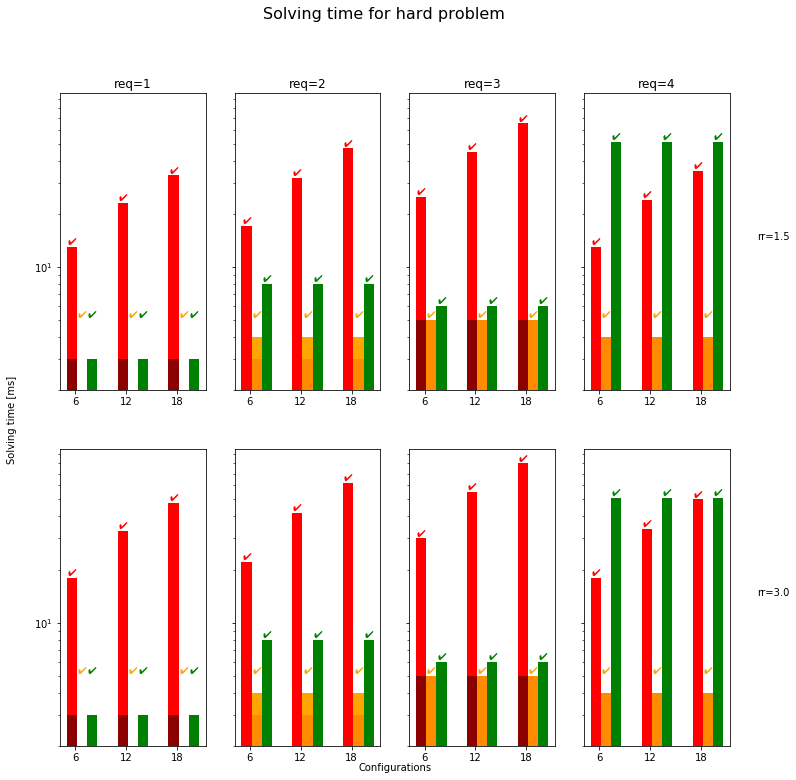

In [14]:
create_grid_plot('incremental/handcrafted-benchmark-1.csv')

nrDifferentRequests: 5 nrDifferentRatios: 8


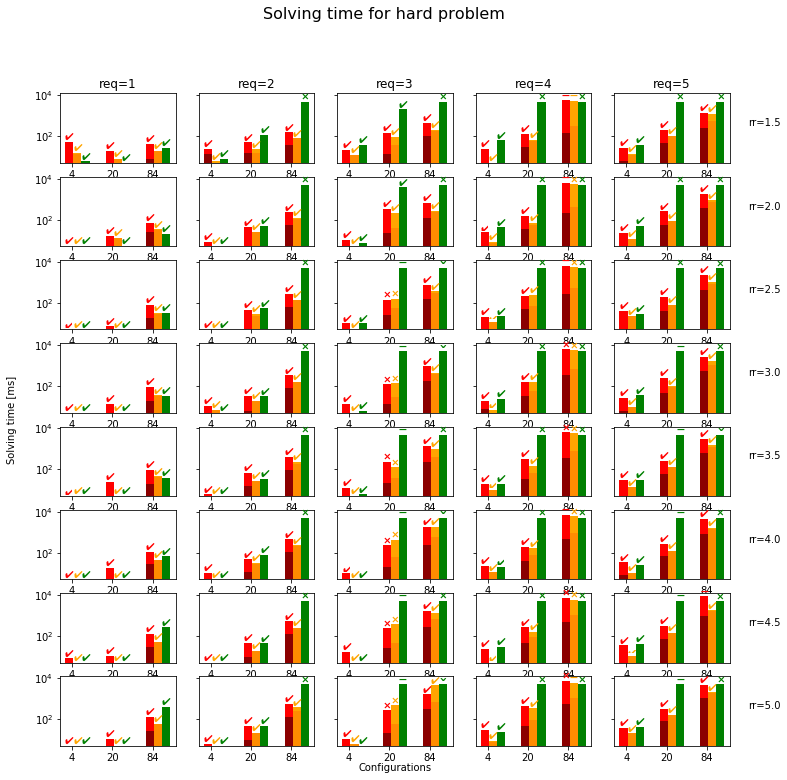

In [16]:
create_grid_plot('http://141.76.65.44:8080/jastadd-mquat-benchmark/results/basic/benchmark-2018-01-24-16-18-58.csv', suffix='')